# DAV 6150 Module 13

- by Group Manling Yang, Xiaojia He, Qi Sun

***
## Introduction

The purpose of this study is to build neural network models to predict the cut class of a given diamond. We'll build three models with different parameters, evaluate their performances, and choose a best one.

<img src="https://raw.githubusercontent.com/susanqisun/DAV-6150/master/assignments/picture/gia-diagramcut.jpg" width="500">

This dataset is comprised of 53940 observations with 10 variables.

**Independent variables:**

1. price: price in US dollars (\$326--\$18,823), continuous data.

2. carat: weight of the diamond (0.2--5.01), continuous data.

3. color: diamond colour, from D (best) to J (worst), ordinal data.

4. clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)), categorical data.

5. x: length in mm (0--10.74), continuous data.

6. y: width in mm (0--58.9), continuous data.

7. z: depth in mm (0--31.8), continuous data.

8. depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79), , continuous data.

9. table: width of top of diamond relative to widest point (43--95), continuous data.

**Dependent variable:**

**cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal), ordinal data

<img src="https://raw.githubusercontent.com/susanqisun/DAV-6150/master/assignments/picture/6PannTm.jpg" width="500">

Reference: https://ggplot2.tidyverse.org/reference/diamonds.html 

**Domain Knowledge:**

A diamond’s cut refers to the style in which the stone is shaped. Cut does not mean the jewel’s shape itself but rather the proportions and facets of its design. It's a diamond’s cut that determines its overall look as well as its ability to reflect light. This makes it one of the most important aspects affecting its value.

Diamond cut is defined by five main factors: table, depth, symmetry, polish, and cut grade. These factors are evaluated using the attributes of brilliance, fire, and scintillation. 

https://www.brilliance.com/diamonds/factors-diamond-cut-quality-comparison

In conjunction with diamond cut grade, the carat size of a diamond would affect the physical diameter (face-up size) that an observer sees.

https://beyond4cs.com/carat/weight-vs-cut/

As we know, diamond prices can vary hugely depending on a diamond's shape, cut quality, clarity and color. Therefore, we can assume the price could also predict the diamond cut. The higher price, the better diamond cut. 


In [ ]:
# Importing required libraries.

import pandas as pd
import numpy as np

import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

#disable chained assignments
pd.options.mode.chained_assignment = None 

***
## Step 1: Load data into the data frame from GitHub

After reading the dataset from Github

`.head()` returns the first 5 rows of the dataset. 

In [ ]:
# read the data from Github
data = pd.read_csv('https://raw.githubusercontent.com/mandy941/DAV-Data-Science/master/Gradient%20Descent%20%2B%20Gradient%20Boosting/Project3_Data.csv')
data.head()


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


***
## Step 2: Exploratory Data Analysis


### 1. Data exploration:
`.shape` returns the number of rows by the number of columns for the dataset.

`.describe()` summarizes the count, mean, standard deviation, min, and max for numeric variables. 

`.dtypes` identifies the Data Types.

`.nunique()` returns the number of unique values for each variable.

`.isnull().sum()` checks missing values for each column.

`.count()` returns the count for each variable.

In [ ]:
df = data.copy()
# check the shape for the dataframe
df.shape

(53940, 10)

In [ ]:
# statistical summary of numeric variables:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80


In [ ]:
#Identify the Data Types
df_info = pd.DataFrame(df.dtypes,columns=['Dtype'])

#Identify the unique values
df_info['Nunique'] = df.nunique()

#check missing values for each column
df_info['MissingValues']=df.isnull().sum()

# Identify the count for each variable
df_info['Count']=df.count()

# Identify the zero values for each variable
df_info['ZeroValues']=(df==0).sum()

# how many '?' values
df_info['?Values']=(df=='?').sum()

df_info

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,Dtype,Nunique,MissingValues,Count,ZeroValues,?Values
carat,float64,273,0,53940,0,0
cut,object,5,0,53940,0,0
color,object,7,0,53940,0,0
clarity,object,8,0,53940,0,0
depth,float64,184,0,53940,0,0
table,float64,127,0,53940,0,0
price,int64,11602,0,53940,0,0
x,float64,554,0,53940,8,0
y,float64,552,0,53940,7,0
z,float64,375,0,53940,20,0


There is no 0mm length, width, or depth diamond in the world. So, there are some mistakes in observations where x, y, or z columns have zero values. Consider we have 53940 observations and fewer zero values in column x, y, z, we will drop them later. 

### 2. Visualize numerical variables

In [ ]:
# define numerical, categorical, and boolean data
numerical_columns = []
boolean_column = []
categorical_columns = []

for i in df.columns[:]:
    if(df[i].dtype=='object'):
        categorical_columns.append(i)
    elif (df[i].dtype=='bool'):
        boolean_column.append(i)
    else:
        numerical_columns.append(i)
        
print('1. Numerical variables:',numerical_columns)
print('2. Boolean variable:',boolean_column)
print('3. Categorical variables:',categorical_columns)


1. Numerical variables: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
2. Boolean variable: []
3. Categorical variables: ['cut', 'color', 'clarity']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f152b560d68>,
      dtype=object)

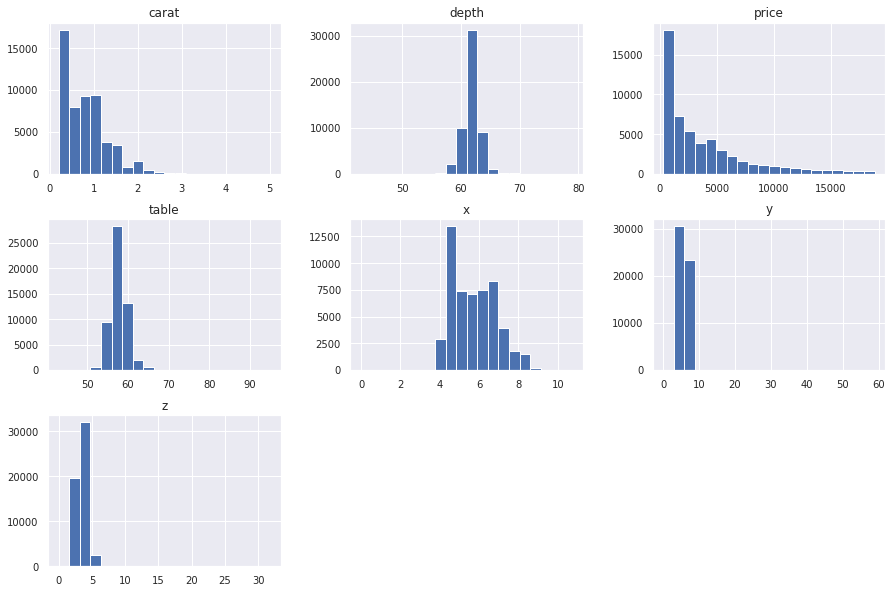

In [ ]:
# Distributions for each of numerical variables.
df[numerical_columns].hist(figsize=(15, 10), bins=20, xlabelsize=10, ylabelsize=10)

1. In the dataset, most of the diamonds are equal or less than 1 carat. Their width of the top of the diamond relative to the widest point is less than 60, and their price is less than 5000 dollars. 
2. Most of the diamonds have 4-5 lengths, 3-9 width, and 2-5 depth. 

### 3. Visualize categorical variables

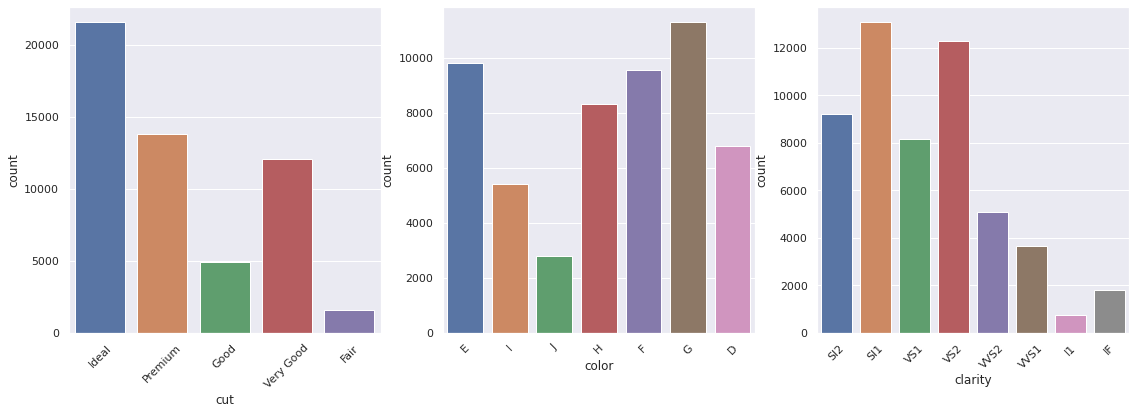

In [ ]:
# create bar chart for categorical data
fig, ax = plt.subplots(1, 3, figsize=(19, 6))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

1. Ideal, Premium, and Very Good level are the top 3 cut levels in all diamonds. There are around 5000 diamonds are in Good cut level. Approximately 2500 diamonds are in a Fair cut level.
2. Most of the diamonds are closed to the best and middle-level colors.  E, G, and F  are the most common  Color levels.  
3. Most of the diamonds are SI1 and VS2 clarity levels. 

### 4. Check the relationship between independent variables and the dependent variable


cut,Fair,Good,Ideal,Premium,Very Good
color,,,,,
D,163,662,2834,1603,1513
E,224,933,3903,2337,2400
F,312,909,3826,2331,2164
G,314,871,4884,2924,2299
H,303,702,3115,2360,1824
I,175,522,2093,1428,1204
J,119,307,896,808,678


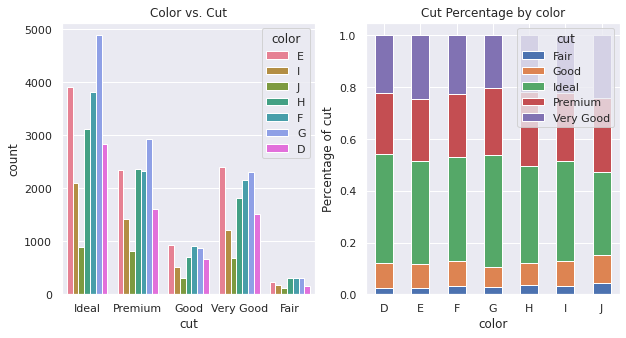

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)

# show the relationship of color and cut
plt.subplot(121)
sns.countplot(x='cut',hue= 'color', data=df, palette = 'husl')
plt.title('Color vs. Cut')

# check the different cut percentages in every color 
ax= plt.subplot(122)
c_c = pd.crosstab(df.color, df.cut)
c_c.div(c_c .sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=ax)
plt.title('Cut Percentage by color')
plt.xlabel('color')
plt.xticks(rotation=0)
plt.ylabel('Percentage of cut')

c_c

1. Most of the diamonds have an ideal, premium, very Good level cut. 
2. Color may appear to be relatively more “predictive” of the response variable because each color contains all types of diamonds cutting level. It is beneficial for us to predict which of the five cut values is most likely to apply to a given observation.

cut,Fair,Good,Ideal,Premium,Very Good
clarity,,,,,
I1,210,96,146,205,84
IF,9,71,1212,230,268
SI1,408,1560,4282,3575,3240
SI2,466,1081,2598,2949,2100
VS1,170,648,3589,1989,1775
VS2,261,978,5071,3357,2591
VVS1,17,186,2047,616,789
VVS2,69,286,2606,870,1235


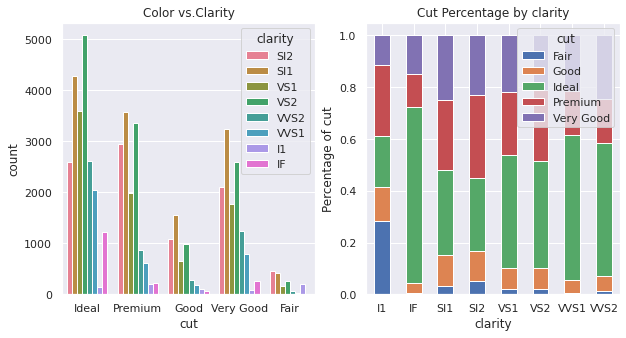

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)

# compare the clarity with cut
plt.subplot(121)
sns.countplot(x='cut',hue= 'clarity', data=df, palette = 'husl')
plt.title('Color vs.Clarity')

# check the cur percentage of clarity
ax= plt.subplot(122)
c2_c = pd.crosstab(df.clarity, df.cut)
c2_c.div(c2_c .sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=ax)
plt.title('Cut Percentage by clarity')
plt.xlabel('clarity')
plt.xticks(rotation=0)
plt.ylabel('Percentage of cut')

c2_c

1. Similar to the color, clarity may appear to be relatively more “predictive” of the response variable.
2. SI1 and VS2 are the top 2 popular clarity types in each diamond's cutti

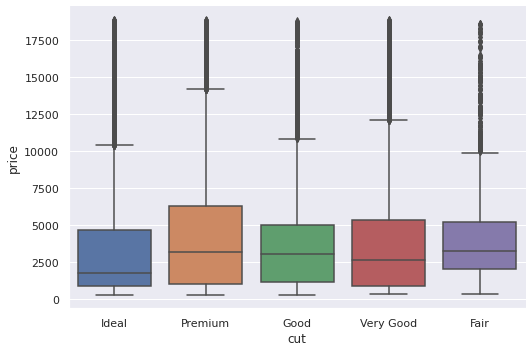

In [ ]:
# plot price vs cut
sns.catplot(x='cut', y='price', data=df, kind='box' ,aspect=1.5 )

plt.xlabel('cut')
plt.ylabel('price')
plt.show()

Premium cut level diamonds has the largest price range and highest median price in all cut levels. And the Ideal cut level diamonds have the lowest median price. 

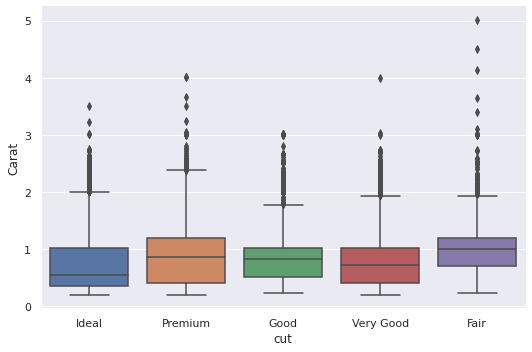

In [ ]:
# plot Carat vs cut
sns.catplot(x='cut', y='carat', data=df, kind='box' ,aspect=1.5 )

plt.xlabel('cut')
plt.ylabel('Carat')
plt.show()

Similar to the price, Premium cut level diamonds have the largest range and highest median carat in all cut levels. And the Ideal cut level diamonds have the lowest median carat. 

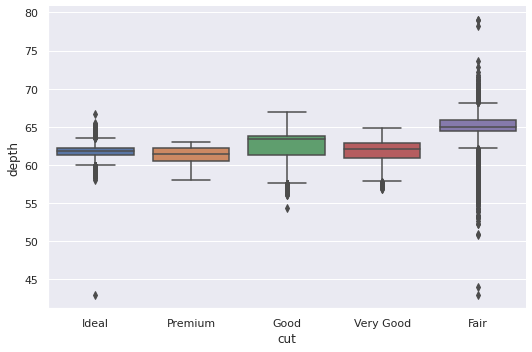

In [ ]:
# plot depth vs cut
sns.catplot(x='cut', y='depth', data=df, kind='box' ,aspect=1.5 )

plt.xlabel('cut')
plt.ylabel('depth')
plt.show()


Good cut level diamonds have the largest range. Fair cut level diamonds have the highest median diamonds' depth at all cut levels.  And the Premium cut level diamonds have the lowest median price. 

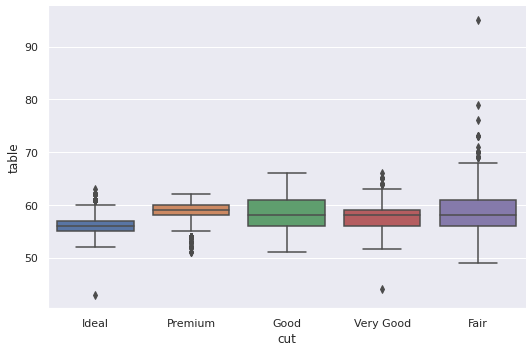

In [ ]:
# plot table vs cut
sns.catplot(x='cut', y='table', data=df, kind='box' ,aspect=1.5 )

plt.xlabel('cut')
plt.ylabel('table')
plt.show()

Good cut level diamonds have the largest range. Premium cut level diamonds have the highest median diamonds' width of the top of diamond relative to widest point at all cut levels.  And the Ideal cut level diamonds have the lowest median width of the top of the diamond relative to the widest point. 

***
## Step 3: Data Cleaning


### 1. Label the dependent variable

In [ ]:
df1 = df.copy()

# use number to replace category in 'cut' column
df2 = df1.replace({'cut': {'Fair':0,'Good':1, 'Ideal': 2, 'Premium':3, 'Very Good': 4}})
df2.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### 2. Handle the zero value

There are some rows with zero values in the columns of x (length), y(width), or z(depth), N=20. We'll delete the rows with zero x,y or z since the dimond's length, width and depth should not be 0.


In [ ]:
# extract the rows that contain 0 value 
null_data = df2.loc[(df2['x']==0) | (df2['y']==0) | (df2['z']==0)]
null_data

,carat,cut,color,clarity,depth,table,price,x,y,z
2207,1.00,3,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2314,1.01,3,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4791,1.10,3,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5471,1.01,3,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10167,1.50,1,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11182,1.07,2,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11963,1.00,4,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13601,1.15,2,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15951,1.14,0,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24394,2.18,3,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


In [ ]:
# get the length of null data
len(null_data)

20

In [ ]:
# Dropping Rows with 'Zero'.
df3 = df2[(df2[['x','y','z']] != 0).all(axis=1)]

In [ ]:
# Just to Confirm the zero 
df3.loc[(df3['x']==0) | (df3['y']==0) | (df3['z']==0)]

,carat,cut,color,clarity,depth,table,price,x,y,z


### 3. Create a New Feature 'Volume'

We discover feature x, y, and z is multicollinearity above, they can seem like as one feature. Consider a formula, diamond's depth * width * length = the diamond's volume, we decide to drop x, y, and z columns and create the Volume column. 

In [ ]:
df3['volume'] = df3['x']*df3['y']*df3['z']
df3.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,0.23,2,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,3,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,1,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,3,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,1,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250


### 4. Drop the fatures of x, y, z

In [ ]:
# drop the features
df3.drop(['x','y','z'], axis=1, inplace= True)

In [ ]:
df3.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'volume'],
      dtype='object')

### 5. Convert categorical variable into dummy variables

In [ ]:
categorical_independent = ['color', 'clarity']

In [ ]:
df_dummy = pd.get_dummies(df3,columns=categorical_independent)
df_dummy.head()

,carat,cut,depth,table,price,volume,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,2,61.5,55.0,326,38.202030,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,3,59.8,61.0,326,34.505856,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,1,56.9,65.0,327,38.076885,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,3,62.4,58.0,334,46.724580,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0.31,1,63.3,58.0,335,51.917250,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
print("check the column names:", df_dummy.columns.tolist())
print("\n")
print("total number of columns: ", len(df_dummy.columns.tolist()))

check the column names: ['carat', 'cut', 'depth', 'table', 'price', 'volume', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']


total number of columns:  21


### 6. Split the data into train and test

In [ ]:
from sklearn.model_selection import train_test_split

X = df_dummy.drop(['cut'], axis=1)
y = df_dummy['cut']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

### 7. Feature Scaling - MinMaxScaler

We'll use the MinMaxScaler to rescale variables into the range [0,1].

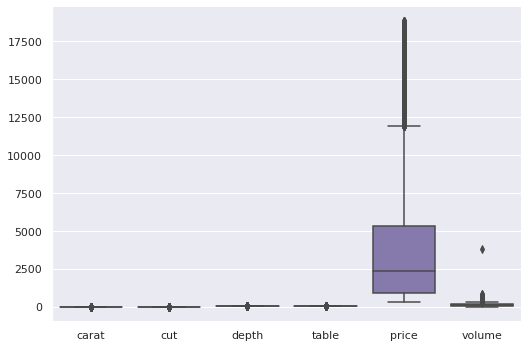

In [ ]:
# plot numerical features (non-dummy features) before scaling
sns.catplot(data=df3 , kind='box' , aspect=1.5)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_std = ['carat', 'depth', 'table', 'price', 'volume']

# Applying Feature Scaling
sc = MinMaxScaler()
X_train[columns_std] = sc.fit_transform(X_train[columns_std])

X_test[columns_std] = sc.transform(X_test[columns_std])

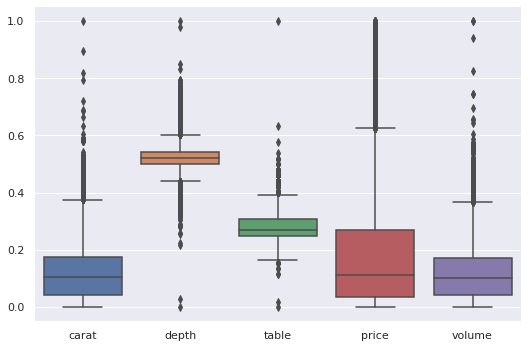

In [ ]:
# plot after Applying Feature Scaling ( MinMaxScaler )
sns.catplot(data=X_train[columns_std] , kind='box' , aspect=1.5)


After Applying Feature Scaling,  the price of diamonds has the largest range. The depth of diamonds has the highest median (around 0.5).  The volume and carat have the lowest median. 

***
## Step 4:Prepped Data Review

#### 1) Check columns: 

The total number of columns has changed from 10 to 21.

In [ ]:
print("check the column names:", df_dummy.columns.tolist())
print("\n")
print("total number of columns: ", len(df_dummy.columns.tolist()))

check the column names: ['carat', 'cut', 'depth', 'table', 'price', 'volume', 'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']


total number of columns:  21


#### 2) Check the shape of the training set and the testing set

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)

Training Features Shape: (43136, 20)
Testing Features Shape: (10784, 20)


#### 3) Check distributions for each of numerical variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e34d10320>,
      dtype=object)

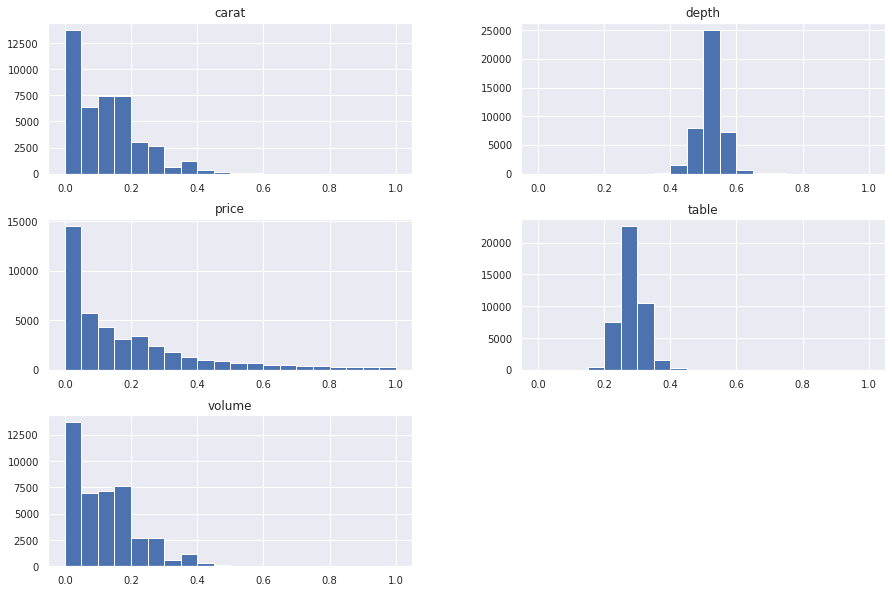

In [ ]:
# Distributions for each of numerical variables
X_train[columns_std].hist(figsize=(15, 10), bins=20, xlabelsize=10, ylabelsize=10)

After data preparation, there is no much change for each numerical column.

#### 4) Check volume (new feature) vs cut

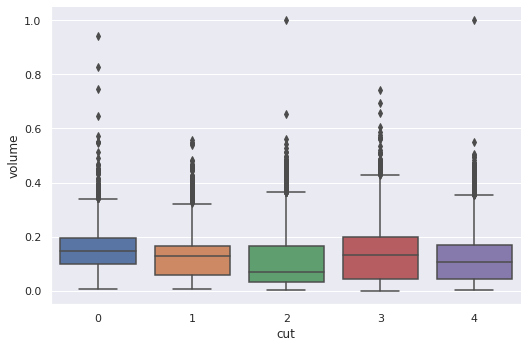

In [ ]:
# plot volume vs cut
# merge training set
df_train = pd.concat([X_train, y_train], axis=1)

sns.catplot(x='cut', y='volume', data=df_train, kind='box' ,aspect=1.5 )

plt.xlabel('cut')
plt.ylabel('volume')
plt.show()

Premium cut level diamonds have the largest range. Fair cut level's diamonds have the highest median price in all cut levels. And the Ideal cut level diamonds have the lowest median price. 

***
## Step 5. Neural Network Modeling + Select Models

We'll perform feature selection firstly. Then, we'll build  three different Python-based feed-forward, back propagating neural network models using the same explanatory variables for each model. 

We'll firstly build a model using the default parameters. Then we'll use the method of sklearn-deap `EvolutionaryAlgorithmSearchCV` to optimize parameters for the second model. Next, we'll use `RandomizedSearchCV`  for optimizing parameters for the third model. 

https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Also, we'll compare the model performance by using 5-fold cross validation and evaluate models based on accuracy, recall, and F1. Since the dependent variable is multi-class not binary class, we'll use macro-averaged Recall and F1 scores, which calculate metrics for each class individually and then takes unweighted mean of the measures. For the accuracy, we'll check and compare it with the null error rate. 

**Check null error rate:**

Null error rate: it is used to define how many times your prediction would be wrong if you can predict the majority class.



In [ ]:
# https://www.ritchieng.com/machine-learning-evaluate-classification-model/
# calculate null error rate (for multi-class classification problems)
y_test.value_counts().head(1)/len(y_test)

2    0.401057
Name: cut, dtype: float64

In [ ]:
y_test.value_counts()

2    4325
3    2768
4    2363
1     988
0     340
Name: cut, dtype: int64

This means that a dumb model that always predicts the majority class (2) would be right 40% of the time. It's a good way to know the minimum we should achieve with our models. 

**Create a function for model evaluation on the training set:**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Create a function for Model Evaluation Using Cross-Validation
def cross_val_score_multilabel (model, X_train, y_train):
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall_macro')
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    print('Model Mean Accuracy (training set):{} '.format(np.mean(accuracy_scores)))
    print('Macro Recall (training set):{} '.format(np.mean(recall)))
    print('Macro F1 score (training set):{} '.format(np.mean(f1)))

### 5.1 Feature Selection - Tree-based `SelectFromModel`

We'll also use SelectFromModel RandomForest to select features based on feature importance. We calculate feature importance using node impurities in each decision tree. In Random forest, the final feature importance is the average of all decision tree feature importance.

https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2



In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=20)
embeded_rf_selector.fit(X_train, y_train.values.ravel())

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

5 selected features


In [ ]:
embeded_rf_feature

['carat', 'depth', 'table', 'price', 'volume']

The features selected in this step corresponds to our domain knowledge findings. Therefore, we'll use 5 features for Classifier Modeling, they are 'carat', 'depth', 'table', 'price', and 'volume'. 


In [ ]:
# Model with five features:
X_train_new = X_train[['carat', 'depth', 'table', 'price', 'volume']]

X_test_new = X_test[['carat', 'depth', 'table', 'price', 'volume']]

print('Training Features Shape:', X_train_new.shape)
print('Testing Features Shape:', X_test_new.shape)

Training Features Shape: (43136, 5)
Testing Features Shape: (10784, 5)


### 5.2 Neural Network Modeling

A neural network executes in two phases: Feed-Forward and Back Propagation. One cycle of feed-forward and back propagation is called one "epoch". The process of creating a neural network begins with the perceptron. The perceptron receives inputs, multiplies them by some weights, and then passes them into an activation function (such as logistic, relu, tanh, identity) to produce an output. This process continues until a reasonable accuracy is achieved. For this study, we'll build neural network machine learning models using scikit-learn. 

We will use `MLPClassifier()`(the Multi-Layer Perceptron Classifier model) to create our neural network that can perform this classification task. The parameter of 'max_iter' denotes the number of epochs.

First of all, we'll build a Neural Network model with the default parameters. Then, we will explore two different methods for optimizing hyperparameters:
* sklearn-deap using evolutionary (algorithms instead of gridsearch in scikit-learn)

 https://scikit-learn.org/stable/related_projects.html#related-projects
 
* Random Search

#### 1) Model 01. Model with default hyperparameters


In [ ]:
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


In [ ]:
# print all the default parameters in the Neural Network model
from sklearn.neural_network import MLPClassifier

#Initializing the MLPClassifier
classifier01 = MLPClassifier()

from pprint import pprint

# Look at default parameters 
print('Parameters currently in use:\n')
pprint(classifier01.get_params())

Parameters currently in use:

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


In [ ]:
### Model 01 ###

#Initializing the MLPClassifier
classifier01 = MLPClassifier()

#Fitting the training data
classifier01.fit(X_train_new, y_train)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

#### 2) Model 02. Tune hyperparameters by using sklearn-deap `EvolutionaryAlgorithmSearchCV `

We'll use evolutionary algorithms instead of gridsearch in scikit-learn. This allows us to reduce the time required to find the best parameters for your estimator. Instead of trying out every possible combination of parameters, evolve only the combinations that give the best results.

https://github.com/rsteca/sklearn-deap


There are several hyperparameters but we will try to adjust the following set of them since we think them may be more affected in our models:

1. hidden_layer_sizes: is used to set the size of the hidden layers. 

2. activation: the activation function for the hidden layer.
* ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x
* ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).
* ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

3. solver: this parameter specifies the algorithm for weight optimization across the nodes.
* ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
* ‘sgd’ refers to stochastic gradient descent.
* ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

4. max_iter: It denotes the number of epochs.

5. learning_rate: Learning rate schedule for weight updates. It inlcude‘constant’, ‘invscaling’, and ‘adaptive’, default=’constant’. 

6. alpha: default=0.0001, L2 penalty (regularization term) parameter.




In [ ]:
param_grid = {
    'activation' : ['tanh', 'relu'],
    'solver' : ['sgd', 'adam'],
    'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,)],
    'max_iter': [100, 200, 300, 500],
    'alpha': [0.0001, 0.05],
    'learning_rate': ["constant", "invscaling", "adaptive"],
}


In [ ]:
# https://github.com/rsteca/sklearn-deap/blob/master/test.ipynb
from sklearn.neural_network import MLPClassifier
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.model_selection import StratifiedKFold

if __name__=="__main__":
    #pool = Pool(4)
    cv = EvolutionaryAlgorithmSearchCV(estimator=MLPClassifier(),
                                       params=param_grid,
                                       scoring="accuracy",
                                       cv=StratifiedKFold(n_splits=2),
                                       verbose=True,
                                       population_size=50,
                                       gene_mutation_prob=0.10,
                                       tournament_size=3,
                                       generations_number=5)
                                       #pmap = pool.map)
    %time cv.fit(X_train_new, y_train)

Types [1, 1, 1, 1, 2, 1] and maxint [1, 1, 9, 3, 1, 2] detected
--- Evolve in 960 possible combinations ---
gen	nevals	avg    	min     	max     	std     
0  	50    	0.54132	0.245989	0.686642	0.101927
1  	36    	0.606131	0.48201 	0.700946	0.0423914
2  	25    	0.627799	0.391738	0.700946	0.0415297
3  	20    	0.655472	0.581347	0.700946	0.0269992
4  	32    	0.671204	0.581255	0.700946	0.0252584
5  	35    	0.680341	0.590389	0.700946	0.0242719
Best individual is: {'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (7,), 'max_iter': 500, 'alpha': 0.0001, 'learning_rate': 'constant'}
with fitness: 0.7009458456973294
CPU times: user 45min 6s, sys: 24.2 s, total: 45min 30s
Wall time: 45min 9s


In [ ]:
### Model02 with tuned parameters ###

classifier02 = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(7,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

classifier02.fit(X_train_new,y_train.values.ravel())


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(7,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

#### 3) Model 03. Tune hyperparameters by using `RandomizedSearchCV`

Next we'll use `RandomizedSearchCV` for optimizing parameters. Random search differs from grid search mainly in that it searches the specified subset of hyperparameters randomly instead of exhaustively. `RandomizedSearchCV` decreases the processing time since it goes through only a fixed number of hyperparameter settings. It moves within the grid in random fashion to find the best set hyperparameters. This approach reduces unnecessary computation.

Very similar to evolutionary search above, we define the hyperparameters to search over before running the search. We'll use the same grid of parameters for `RandomizedSearchCV`.

https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624


In [ ]:
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.neural_network import MLPClassifier

# Instantiating RandomizedSearchCV object 
clf02 = RandomizedSearchCV(MLPClassifier(random_state=0), param_grid, cv=3,
                           scoring='accuracy')

clf02.fit(X_train_new, y_train.values.ravel()) 

print("Best parameters from RandomizedSearchCV: {}".format(clf02.best_params_)) 


Best parameters from RandomizedSearchCV: {'solver': 'adam', 'max_iter': 500, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (9,), 'alpha': 0.0001, 'activation': 'tanh'}


In [ ]:
### Model03 with tuned parameters ###

classifier03 = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(9,), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

classifier03.fit(X_train_new,y_train.values.ravel())

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(9,), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### 5.3 Neural Network Model Evaluation on training set

We'll compare the models by using 5-fold cross validation on the training set and evaluate models based on accuracy, recall, and F1. Since the dependent variable is multi-class not binary class, we'll use macro-averaged Recall and F1 scores, which calculate metrics for each class individually and then takes unweighted mean of the measures. For the accuracy, we'll check and compare it with the null error rate.


In [ ]:
# Model 01:
cross_val_score_multilabel (classifier01, X_train_new, y_train.values.ravel())

Model Mean Accuracy (training set):0.7131398125334425 
Macro Recall (training set):0.6551837611492694 
Macro F1 score (training set):0.6673258713404552 


In [ ]:
# Model 02:
cross_val_score_multilabel (classifier02, X_train_new, y_train.values.ravel())


Model Mean Accuracy (training set):0.7046782591489807 
Macro Recall (training set):0.6494868823241093 
Macro F1 score (training set):0.6598178983587775 


In [ ]:
# Model 03:
cross_val_score_multilabel (classifier03, X_train_new, y_train.values.ravel())

Model Mean Accuracy (training set):0.6818897248716026 
Macro Recall (training set):0.6073629405523061 
Macro F1 score (training set):0.6193722752499513 


**Neural Network Model Evaluation Results:**


| Metric        | Model 01 | Model 02 | Model 03 |
| ------------- | ------- | ------- | ------- |
| # Indep. Vars |  5     |   5     |   5     |    
| The Accuracy of the model  | 0.705  | 0.682 |  0.682      |
| Macro F1 Score      | 0.667  |0.66 |  0.619      |
| Macro Recall           |0.655 | 0.649 |  0.607  |

**Results:**

From the results above, the Model01 performs better than the other two models. We can see that the Model01 with default parameters has the highest accuracy, macro F1, and macro recall scores that means the Model01 works better. The accuacy is higher than the null error rate. Also, the Model01 spent the least time to run. Therefore, for the Neural Network model, we select the Model01 with 5 features and default parameters as our best model.





### 5.4 Apply the final preferred model to the testing subset:

Since this is a multi-class classification, we'll use `multilabel_confusion_matrix` to compute a confusion matrix for each class. 

In [ ]:
#predict on the testing set
y_pred_final = classifier01.predict(X_test_new)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

print("Best Neural Network Model model:")
mcm01 = multilabel_confusion_matrix(y_test, y_pred_final)
print("Multi-label Confusion Matrix\n{}".format(mcm01))
print("Classification Report")
print(classification_report(y_test, y_pred_final))

Best Neural Network Model model:
Multi-label Confusion Matrix
[[[10408    36]
  [   79   261]]

 [[ 9459   337]
  [  374   614]]

 [[ 5528   931]
  [  351  3974]]

 [[ 6844  1172]
  [  607  2161]]

 [[ 7825   596]
  [ 1661   702]]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       340
           1       0.65      0.62      0.63       988
           2       0.81      0.92      0.86      4325
           3       0.65      0.78      0.71      2768
           4       0.54      0.30      0.38      2363

    accuracy                           0.72     10784
   macro avg       0.70      0.68      0.68     10784
weighted avg       0.70      0.72      0.70     10784



In [ ]:
#predict on the training set
y_pred_train = classifier01.predict(X_train_new)

mcm02 = multilabel_confusion_matrix(y_train, y_pred_train)
print("Multi-label Confusion Matrix\n{}".format(mcm02))
print("Classification Report")
print(classification_report(y_train, y_pred_train))

Multi-label Confusion Matrix
[[[41743   124]
  [  300   969]]

 [[37941  1281]
  [ 1501  2413]]

 [[22332  3581]
  [ 1503 15720]]

 [[27334  4790]
  [ 2319  8693]]

 [[30941  2477]
  [ 6630  3088]]]
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1269
           1       0.65      0.62      0.63      3914
           2       0.81      0.91      0.86     17223
           3       0.64      0.79      0.71     11012
           4       0.55      0.32      0.40      9718

    accuracy                           0.72     43136
   macro avg       0.71      0.68      0.69     43136
weighted avg       0.70      0.72      0.70     43136



**Compare train and test - Neural Network Model Evaluation:**


| Metric        | Model used in training set | Model used in testing set|
| ------------- | ------- | ------- | 
| # Indep. Vars |  5     |   5    |     
| The Accuracy of the model  | 0.72  | 0.72  | 
| macro F1 Score      | 0.69  | 0.68  | 
| macro Recall           |0.68  | 0.68 | 



From the results above, the Neural Network Model01 performs as well as expected in the testing set. 

***
## Step 6. Conclusion

### Feature Importances with ELI5:

We'll use ELI5 to inspect the feature importance for the best Neural Network model we selected above. The `PermutationImportance` is a way to understand blackbox models. We'll import eli5 and use `show_weights` to visualise the weights of our model, which shows relative importance among the features. 

https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
perm = PermutationImportance(classifier01).fit(X_test_new, y_test)
eli5.show_weights(perm,feature_names=list(X_test_new.columns), show_feature_values=True)

Weight,Feature
0.2653 ± 0.0064,table
0.2376 ± 0.0031,carat
0.1839 ± 0.0055,depth
0.1438 ± 0.0035,price
0.1364 ± 0.0067,volume


**Results:**

The table abve gives average importance and standard deviation. The results of this table shows that the most important feature to predict a diamond cut is the diamond table. It means when we use this model on new data to predict diamond cut, the most important thing it will need to get the prediction right is the class of a diamond table. Next is diamond carat. The diamond volume is the least important feature to make a prediction. 